Notebook to compute the eigenmode decomposition of 1D diffusion utilizing random walk methodology. Used to validate modal markov formulation for calcium diffusion. Simple 1d diffusion with no reactions.

10 nodes.

author: Margot Wagner
date created: 6/16/22

# 1D Diffusion Eigenmode Decomposition

In [4]:
import numpy as np
from numpy.linalg import eig
import matplotlib.pyplot as plt
import warnings

Define global variables

In [5]:
# create mesh
n_locs = 10               # define number of grid points along 1D line
dt = 1                    # time step (usec)
n_t_pts = 1000            # number of time points

start_loc = 4             # starting position for molecules
min_loc = 0               # minimum position
max_loc = n_locs - 1      # maximum position
last_elem_i = -1          # index for the last element in a list
move = 1                  # number of points a particle can move per timepoint

L = 4                     # total length of diffusion line (um)
N = 50                    # number of molecules
D = 2.20e-4               # Calcium diffusion coeff (um^2/usec)


### 1D Random Walk Diffusion Simulation

(implementation similar to GeeksforGeeks' ["Random Walk (Implementation in Python)"](https://www.geeksforgeeks.org/random-walk-implementation-python/))

In [6]:
def random_walk(N, n_t_pts, p):
    """ 1-D random walk for N molecules from a range of positions = [0, (n_locs - 1)]
    
    Args:
      N: 
        total number of molecules
      n_t_pts:
        number of time points
      p:
        probability of particle diffusing to neighboring grid point
u
    Returns:
      positions of all particles over time - matrix shaped (N, n_t_pts)
    """

    # probabilities depending on if particle is in middle or at edge
    p_middle = [p, 1 - 2*p, p]
    p_edge = [p, 1 - p]

    # initialize array for all particle positions
    all_N_positions = np.empty((N, n_t_pts), dtype='int64')

    for n in range(N):

        # Initialize starting position (0 to (n_locs - 1) range)
        positions = [start_loc]

        # sampling probability all at once (1000 timepoints) 
        r = np.random.random(n_t_pts - 1)

        # movement decision conditions
        move_l_cond = r < p
        move_r_cond = r > (1 - p)
        # stay condition is between the two

        # run simulation for particle n
        # check probability rolls 
        for move_left, move_right in zip(move_l_cond, move_r_cond):
        
            # if move_left is True and last position isn't the minimum position, move left
            left = move_left and positions[last_elem_i] > min_loc 

            # if move_right is True and last position isn't the maximum position, move right  
            right = move_right and positions[last_elem_i] < max_loc

            # stay condition is implied

            # adjust position accordingly 
            positions.append(positions[last_elem_i] - left + right)

        # add results to cumulative array
        all_N_positions[n] = positions
    
    return all_N_positions


* Calculate probability

In [7]:
def find_p(L, n_locs, D, dt):
    """ Find the probability of moving one spot to the left or right based on finite-difference approximations

    params:
        L:
            length of line on which molecule is diffusing
        n_locs:
            number of locations molecule can diffuse to
        D: 
            calcium diffusion constant
        dt: 
            time step 

    return:
        probability of diffusing one spot to the left or right

    """
    dx = L / n_locs         # distance of one "hop"
    k = D / dx**2             # rate constant

    return k*dt

* Find the number of particles at each node at each time point

In [8]:
def postprocess_rw(all_N_positions, plot=False):
    """Post-process 1D random-walk diffusion (counts, normalized counts, means)
    
    Args:
      all_N_positions: 
        positions of all particles over time - matrix shaped (N, n_t_pts)

    Returns:
      n_per_loc:
        number of particles in each position over time
      p_per_loc:
        number of particles normalized by N in each position over time
      means:
        mean value of particle number at each location over the whole simulation
    """

    # distribution of particles across positions over time
    n_per_loc = np.zeros((n_locs, n_t_pts), dtype='int64')      # number of particles over time
    p_per_loc = np.zeros((n_locs, n_t_pts))                     # normalized count over time

    for i in range(n_t_pts):
        # count number of particles in each position
        counts = np.bincount(all_N_positions[:,i])

        # resize to include all positions if it doesn't already
        counts.resize(n_locs)

        # assign number of particles
        n_per_loc[:, i] = counts

        # normalize counts and assign
        counts = counts / all_N_positions.shape[0]
        p_per_loc[:, i] = counts

    means = np.mean(n_per_loc, axis=1)

    if plot==True: 
      # plot particle counts for each position
      plt.figure(figsize=(14,10))

      for i in range(n_locs):
        plt.plot(list(range(n_t_pts)), p_per_loc[i, :])

      plt.title("Normalized number of particles in each position over time", fontsize=20)
      plt.xlabel("timepoint", fontsize=14)
      plt.ylabel("normalized count", fontsize=14)
      plt.legend(list(range(n_locs)))
      plt.show()

    return n_per_loc, p_per_loc, means

* Define transition matrix

In [9]:
def transition_matrix_maker(p, n_locs, is_prob=True):
    """ Builds and returns the transition matrix for the 1D random walk case as given.

    params:
        p: 
            probability
        n_locs: 
            number of grid points along line
        is_prob:
            if the transition matrix is the probabilities (default) or if it is from the ODEs (using k-values)

    returns:

    """

    # Define A (transition) matrix 
    A = np.zeros((n_locs, n_locs))             # transition probability between grid points

    # Transition matrix is given by the probability of transition
    if is_prob:
        vec_diag = np.full(n_locs, (1 - 2*p))           # diagonal values
        vec_off_diag = np.full((n_locs - 1), (p))       # off-diagonal values

        # create transition matrix
        A = np.diag(vec_diag, k=0) + np.diag(vec_off_diag, k=1) + np.diag(vec_off_diag, k=-1)
        A[0,0] = 1 - p
        A[n_locs - 1, n_locs - 1] = 1 - p

    # Transition matrix is given by the ODE dynamics equation (using k-values)
    else:
        vec_off_diag = np.full((n_locs - 1), p/dt)  # off-diagonal values

        # create transition matrix
        A = np.diag(vec_off_diag, k=1) + np.diag(vec_off_diag, k=-1)

    return A
    

* Solve for $q_{\pm k}$

For N = 1
\begin{equation} 
    q_{\pm k} = \frac{1}{2} \pm \frac{\sum_i p_i \text{v}_{i k}}{2\sqrt{\sum_i p_i (\text{v}_{i k})^2}} 
\end{equation}

In [10]:
def q_pm_k(p_per_loc, e_vec):
    """ Find the normalized number of particles in the positive and negative state of eigenmode k

    params:
        p_per_loc: 
            normalized number or particles at node i (vector)
        e_vec:
            eigenvector of node i (vector); v[:,i] is the eigenvector corresponding to the eigenvalue w[i]
    
    return:
        q +- k
    """

    # numerator summation using outer product (element-wise multiplication)
    num_sum = sum([e_vec[i,:].reshape((n_locs, 1)) * p_per_loc for i in range(n_locs)])  

    # denominator summation using outer product (element-wise multiplication) 
    denom_sum = sum([(np.square(e_vec[i,:])).reshape((n_locs, 1)) * p_per_loc for i in range(n_locs)])   

    # ignore divide by zero warning 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        frac = (num_sum / (2 * np.sqrt(denom_sum)))

    # replace nans with zeros
    np.nan_to_num(frac, copy=False)

    q_plus_k = 0.5 + frac
    q_minus_k = 0.5 - frac


    return q_plus_k, q_minus_k

* Main

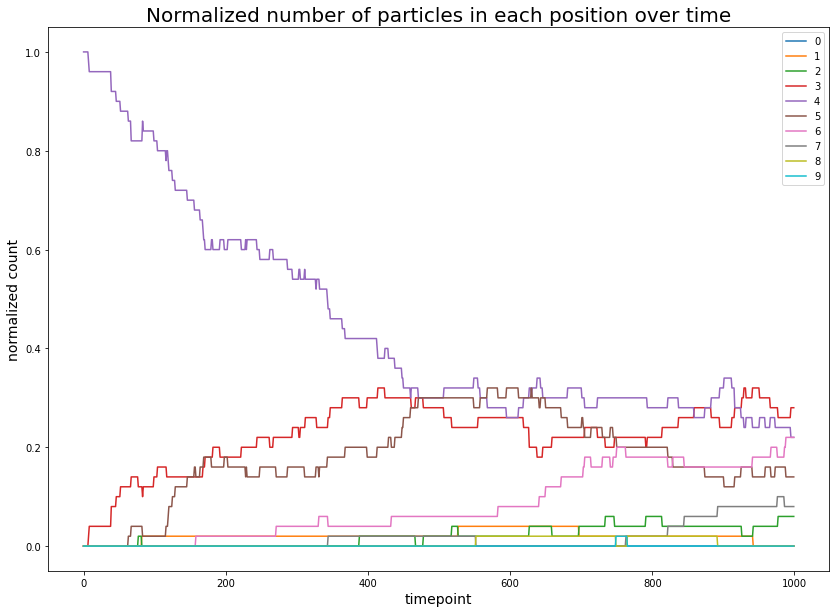

The full solution shape for each q (plus or minus) is (10, 1000)
Initial values for q_plus_k:	 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Initial values for q_minus_k:	 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


In [11]:
def main():
    
    # find probability of moving one step 
    p = find_p(L, n_locs, D, dt)
    
    # run simulation
    all_N_positions = random_walk(N, n_t_pts, p)

    # plot output
    n_per_loc, p_per_loc, means = postprocess_rw(all_N_positions, plot=True)

    # build transition matrix
    A = transition_matrix_maker(p, n_locs, is_prob=True)

    # get eigenvalues/eigenvalues
    e_val, e_vec = eig(A)

    # solve for q +/- k
    q_plus_k, q_minus_k = q_pm_k(p_per_loc, e_vec)

    print("The full solution shape for each q (plus or minus) is", q_plus_k.shape)

    print("Initial values for q_plus_k:\t", q_plus_k[:,0])
    print("Initial values for q_minus_k:\t", q_minus_k[:,0])





if __name__ == '__main__':
    tables_created = main()     

In [ ]:
def modal_transition_matrix_maker(n_modes, e_vals):
    """ Builds and returns markov modal transition matrix given the number of modes and eigenvalues
    
    params:
        n_modes: 
            number of modes (k not +/- k); equal to number of lcoations
        e_vals:
            eigenvalues

    return
    """


In [ ]:
def markov_eigenmode_diffusion(n_modes, init_cond, transition_matrix, dt, n_iter):
    """ Markov simulation for eigenmode analysis to capture calcium diffusion over time
    params:
        n_modes: 
            number of modes (k not +/- k); equal to number of lcoations
        init_cond:
            initial modal values
        transition_matrix:
            matrix containing probabilities of transitioning between states
        dt:
            timestep
        n_iter:
            number of iterations

    return:
    """
    return 0

In [ ]:
# Simulate Markov process for stochastically opening and closing channels
seed = 0
np.random.seed(seed)
def markov_vdcc_n(n_channels,trange,dt):
    '''
    Simulates a Markov process for the stochastic opening and closing of channels using
    multinomial sampling.
    
    @param n_channels (int) - number of channels to model
    @param trange (int/float array) - array over which the simulation takes place
    @param dt (int/float) - time step
    
    @return n_per_state (int array) - number of channels in each state at each time point (shape: [trange, n_states])
    @return ca (int array) - number of calcium that enters at each time point (shape: [trange])
    @return ca_sum (int array) - total sum of calcium that has entered at that time (shape: [trange])
    '''
    n_states = 5
    n_per_state = np.zeros((len(trange), n_states), dtype=int)
    ca = np.zeros(len(trange), dtype=int)
    ca_sum = np.zeros(len(trange), dtype=int)
    
    # All channels start in C0
    n_per_state[0,0] = n_channels
    
    for t_index in range(len(trange)-1):
        p_trans_0 = [1 - alpha_1(trange[t_index])*dt, alpha_1(trange[t_index])*dt, 0, 0, 0]
        samp0 = np.random.multinomial(n_per_state[t_index,0], p_trans_0)
        
        
        p_trans_1 = [beta_1(trange[t_index])*dt, 1 - (beta_1(trange[t_index])*dt + alpha_2(trange[t_index])*dt), 
                           alpha_2(trange[t_index])*dt, 0, 0]
        samp1 = np.random.multinomial(n_per_state[t_index,1], p_trans_1)
        
        
        p_trans_2 = [0, beta_2(trange[t_index])*dt, 1 - (beta_2(trange[t_index])*dt + alpha_3(trange[t_index])*dt), 
                           alpha_3(trange[t_index])*dt, 0]
        samp2 = np.random.multinomial(n_per_state[t_index,2], p_trans_2)
        
        
        p_trans_3 = [0, 0, beta_3(trange[t_index])*dt, 1 - (beta_3(trange[t_index])*dt + alpha_4(trange[t_index])*dt), 
                           alpha_4(trange[t_index])*dt]
        samp3 = np.random.multinomial(n_per_state[t_index,3], p_trans_3)
        
        
        p_trans_4 = [0, 0, 0, beta_4(trange[t_index])*dt, 1 - beta_4(trange[t_index])*dt]
        samp4 = np.random.multinomial(n_per_state[t_index,4], p_trans_4)
        
        ca[t_index+1] = np.random.binomial(n_per_state[t_index,4], k_ca(trange[t_index])*dt)
        ca_sum[t_index+1] = ca[t_index+1] + ca_sum[t_index]
        
        n_per_state[t_index+1,:] = samp0 + samp1 + samp2 + samp3 + samp4
        
    return n_per_state, ca, ca_sum